# OpenCV를 활용한 개체 탐지 후 색 그룹화
  -> 개체 탐지 후 색 추출하여 그룹화

## 개체 탐지

모듈 import

In [2]:
import cv2
import numpy as np

In [3]:
print(cv2.__version__)

4.11.0


In [ ]:
def grabcut_segmentation(image_path):
    # 이미지 로드
    img = cv2.imread(image_path)
    if img is None:
        print("이미지를 불러올 수 없습니다.")
        return
    
    # 창의 종료 버튼 활성화
    cv2.namedWindow("Original Image with Contours", cv2.WINDOW_NORMAL)
    cv2.setWindowProperty("Original Image with Contours", cv2.WND_PROP_TOPMOST, 1)
    cv2.namedWindow("Segmented Object", cv2.WINDOW_NORMAL)
    cv2.setWindowProperty("Segmented Object", cv2.WND_PROP_TOPMOST, 1)
    
    # 마스크 초기화
    mask = np.zeros(img.shape[:2], np.uint8)
    
    # GrabCut을 위한 임시 배열 생성
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # 관심 영역(ROI) 설정 (이미지 중앙 기준)
    height, width = img.shape[:2]
    rect = (int(width*0.1), int(height*0.1), int(width*0.8), int(height*0.8))  # (x, y, w, h)
    
    # GrabCut 실행
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # 배경 제거하여 객체만 남기기
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    segmented = img * mask2[:, :, np.newaxis]
    
    # 경계 검출
    contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 원본 이미지에 경계선을 그림 (초록색, 두께 2)
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    
    # 결과 출력
    cv2.imshow("Original Image with Contours", img)
    cv2.imshow("Segmented Object", segmented)
    
    print("창을 닫으려면 'q' 키 또는 ESC 키를 누르세요.")
    
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC 키 입력 시 닫기
            cv2.destroyAllWindows()
            break
        
        # 창이 닫혔는지 확인 후 종료
        if cv2.getWindowProperty("Original Image with Contours", cv2.WND_PROP_VISIBLE) < 1 or \
           cv2.getWindowProperty("Segmented Object", cv2.WND_PROP_VISIBLE) < 1:
            cv2.destroyAllWindows()
            break
    
    # 남아있는 모든 이벤트 처리 후 창 닫기
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)
    cv2.waitKey(1)

# 실행 예시 (이미지 경로를 입력하여 테스트)
grabcut_segmentation("data/musinsa_images_outer/O2089.jpg")


창을 닫으려면 'q' 키 또는 ESC 키를 누르세요.


2025-02-19 15:14:33.361 Python[6884:381033] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-19 15:14:33.361 Python[6884:381033] +[IMKInputSession subclass]: chose IMKInputSession_Modern


## API로 이미지 불러오기

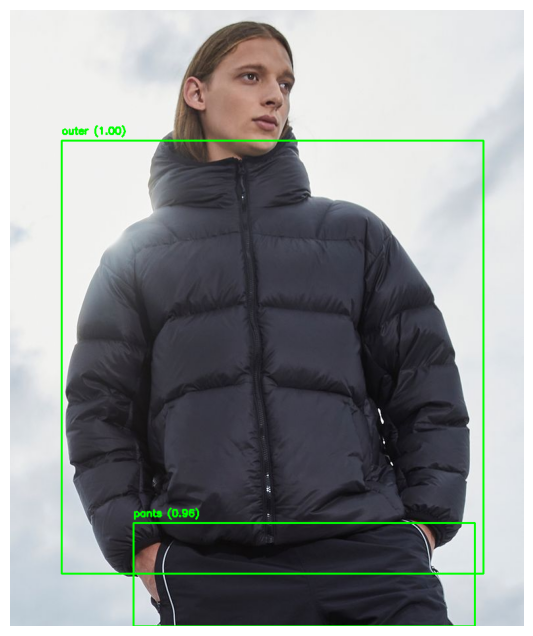

In [ ]:
import requests
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

# Azure Custom Vision API 정보 (사용자가 직접 입력)


# 임계값 설정 (이 값을 조절하여 필터링 가능)
THRESHOLD = 0.7  # 70% 이상 확률인 경우만 표시

def detect_objects(image_path):
    # 이미지 로드
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    # API 요청 헤더 및 데이터
    headers = {
        "Prediction-Key": prediction_key,
        "Content-Type": "application/octet-stream"
    }
    url = f"{prediction_endpoint}/customvision/v3.0/Prediction/{project_id}/detect/iterations/{model_name}/image"
    
    # 요청 전송
    response = requests.post(url, headers=headers, data=image_data)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return None

    # JSON 응답 데이터 파싱
    return response.json()

def visualize_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < THRESHOLD:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 정보 (비율로 주어지므로 실제 좌표로 변환)
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 박스 그리기
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"{tag_name} ({probability:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # 결과 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# 실행 예시
image_file = "data/musinsa_images_outer/O1500.jpg"
detections = detect_objects(image_file)
if detections:
    visualize_detections(image_file, detections)
